In [35]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop, SciplexGRNCellPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "datasets", "Sciplex3", "processed", 
                                  "SrivatsanTrapnell2020_sciplex3_with_all_paths.h5ad")
                     )

In [3]:
sparsity_rand_edges = 0.1
adj_mat = adata.varp["grn_adj_mat"]

adj_mat = adj_mat + np.random.choice([0, 1], size=adj_mat.shape, p=[1.-sparsity_rand_edges, sparsity_rand_edges])

print("edge density", adj_mat.sum() / (4000*4000))
adata.varp["grn_adj_mat"] = adj_mat

edge density 0.1077528125


In [4]:
len(adata)

25581

In [5]:
obs_cells = list(adata.obs[adata.obs['perturbation'] == "control"].index.astype("int"))

In [6]:
obs_adata = adata[obs_cells]

In [7]:
obs_adata

View of AnnData object with n_obs × n_vars = 2613 × 4000
    obs: 'cell_barcode', 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'n_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'gene_name', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '(+)-JQ1_shortest_paths', '2-Methoxyestradiol (2-MeOE2)_shortest_paths', 'AG-14361_shortest_paths', 'AMG-900_shortest_paths', 'AT9283_shortest_paths', 'Abexinostat (PCI-24781)_shortest_paths', 'Alisertib (MLN8237)_shortest_paths', 'BMS-265246_shortest_paths', 'Barasertib (AZD1152-HQPA)_shortest_paths', 'Belinostat (PXD101)_shortest_paths', 'CUDC-101_shortest_paths', 'CYC116_shortest_paths', 'Carmofur_shortest_paths', 'Cediranib (AZD2171)_shortest_paths'

## Model

In [8]:
batch_size = obs_adata.shape[0] // 3
n_latent = 0

In [9]:
mycellpop = SciplexGRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

## Load weights

In [10]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_mar_12_1.pt"), 
                                map_location=torch.device('cpu'))

In [11]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

## Plotting

In [12]:
sc.pp.neighbors(obs_adata, n_neighbors=30, n_pcs=50)

In [13]:
highly_var_gene_list = list(adata.var.iloc[np.where(adata.X.std(axis=0) > 0.01)[0]].index)

In [14]:
len(highly_var_gene_list)

1413

In [15]:
with torch.no_grad():
    
    obs_velocities = []
        
    for i in tqdm(range(obs_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(obs_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(torch.cat((gene_expr, 
                                                        torch.zeros(batch_size, n_latent, 1)), dim=1))
        
        if n_latent > 0:
            obs_velocities.append(velocity[:, :-n_latent])
        else:
            obs_velocities.append(velocity)
        
obs_velocities = torch.cat(obs_velocities).cpu().numpy()[:, :, 0]
obs_adata.layers["velocity"] = obs_velocities
obs_adata.layers["X"] = obs_adata.X

100%|██████████| 3/3 [02:53<00:00, 57.95s/it]


In [16]:
scv.tl.velocity_graph(obs_adata, xkey="X", gene_subset=highly_var_gene_list, n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/2613 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


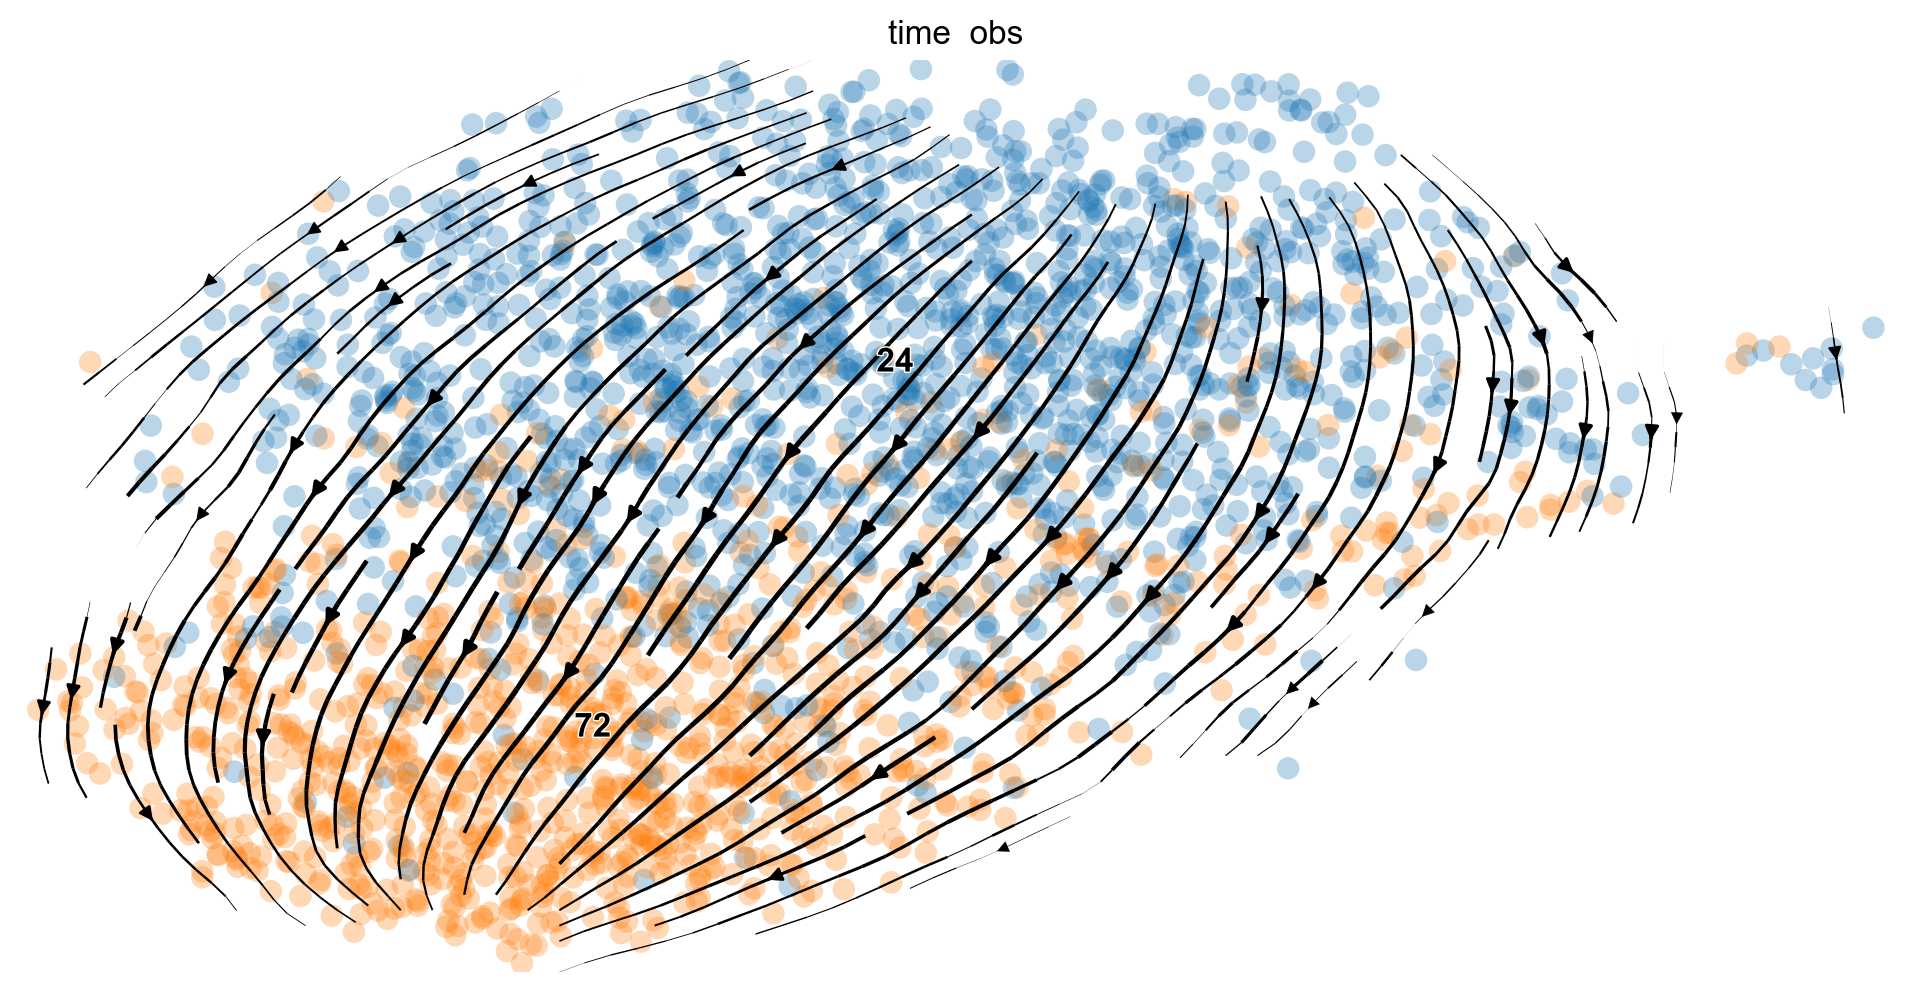

In [17]:
plt.rcParams["figure.figsize"] = (12,6)
scv.pl.velocity_embedding_stream(obs_adata, basis='umap', color="time", layer="obs")

## Simulate trajectories

In [20]:
start_adata = obs_adata[obs_adata.obs["time"] == '24']

In [21]:
start_adata

View of AnnData object with n_obs × n_vars = 1550 × 4000
    obs: 'cell_barcode', 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'n_counts', 'velocity_self_transition'
    var: 'ensembl_id', 'ncounts', 'ncells', 'gene_name', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '(+)-JQ1_shortest_paths', '2-Methoxyestradiol (2-MeOE2)_shortest_paths', 'AG-14361_shortest_paths', 'AMG-900_shortest_paths', 'AT9283_shortest_paths', 'Abexinostat (PCI-24781)_shortest_paths', 'Alisertib (MLN8237)_shortest_paths', 'BMS-265246_shortest_paths', 'Barasertib (AZD1152-HQPA)_shortest_paths', 'Belinostat (PXD101)_shortest_paths', 'CUDC-101_shortest_paths', 'CYC116_shortest_paths', 'Carmofur_shortest_paths', 'Cediran

In [22]:
start_adata.shape[0] / 50

31.0

In [23]:
batch_size = start_adata.shape[0] // 50
mycellpop.change_batch_size(batch_size)

In [24]:
mycellpop

CellPopulation. 4000 nodes and 31 cells.

In [25]:
torch.linspace(0, 1, 10)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [26]:
path_length = 2
all_traj = []

with torch.no_grad():

    for i in tqdm(range(start_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(start_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        
        mycellpop.set_visible_state(gene_expr)
        
        traj = simulate_deterministic_trajectory(mycellpop, torch.linspace(0, path_length-1, 10))
        traj = traj[:, :, :mycellpop.n_genes, 0]

        all_traj.append(traj)
        
#         if i == 4:
#             break

100%|██████████| 50/50 [19:56<00:00, 23.94s/it]


In [27]:
all_traj_cat = torch.cat(all_traj)

In [28]:
obs_times = torch.cat([torch.linspace(0, path_length-1, 10)[None]]*len(all_traj_cat)).reshape(-1).numpy()

In [29]:
traj_adata = ad.AnnData(all_traj_cat.reshape(-1, 4000).numpy(), obs=obs_times)

In [30]:
traj_adata.obs = traj_adata.obs.rename(columns={0: "time"})

In [31]:
sc.tl.pca(traj_adata)
sc.pp.neighbors(traj_adata, n_neighbors=50)
sc.tl.umap(traj_adata, maxiter=600)

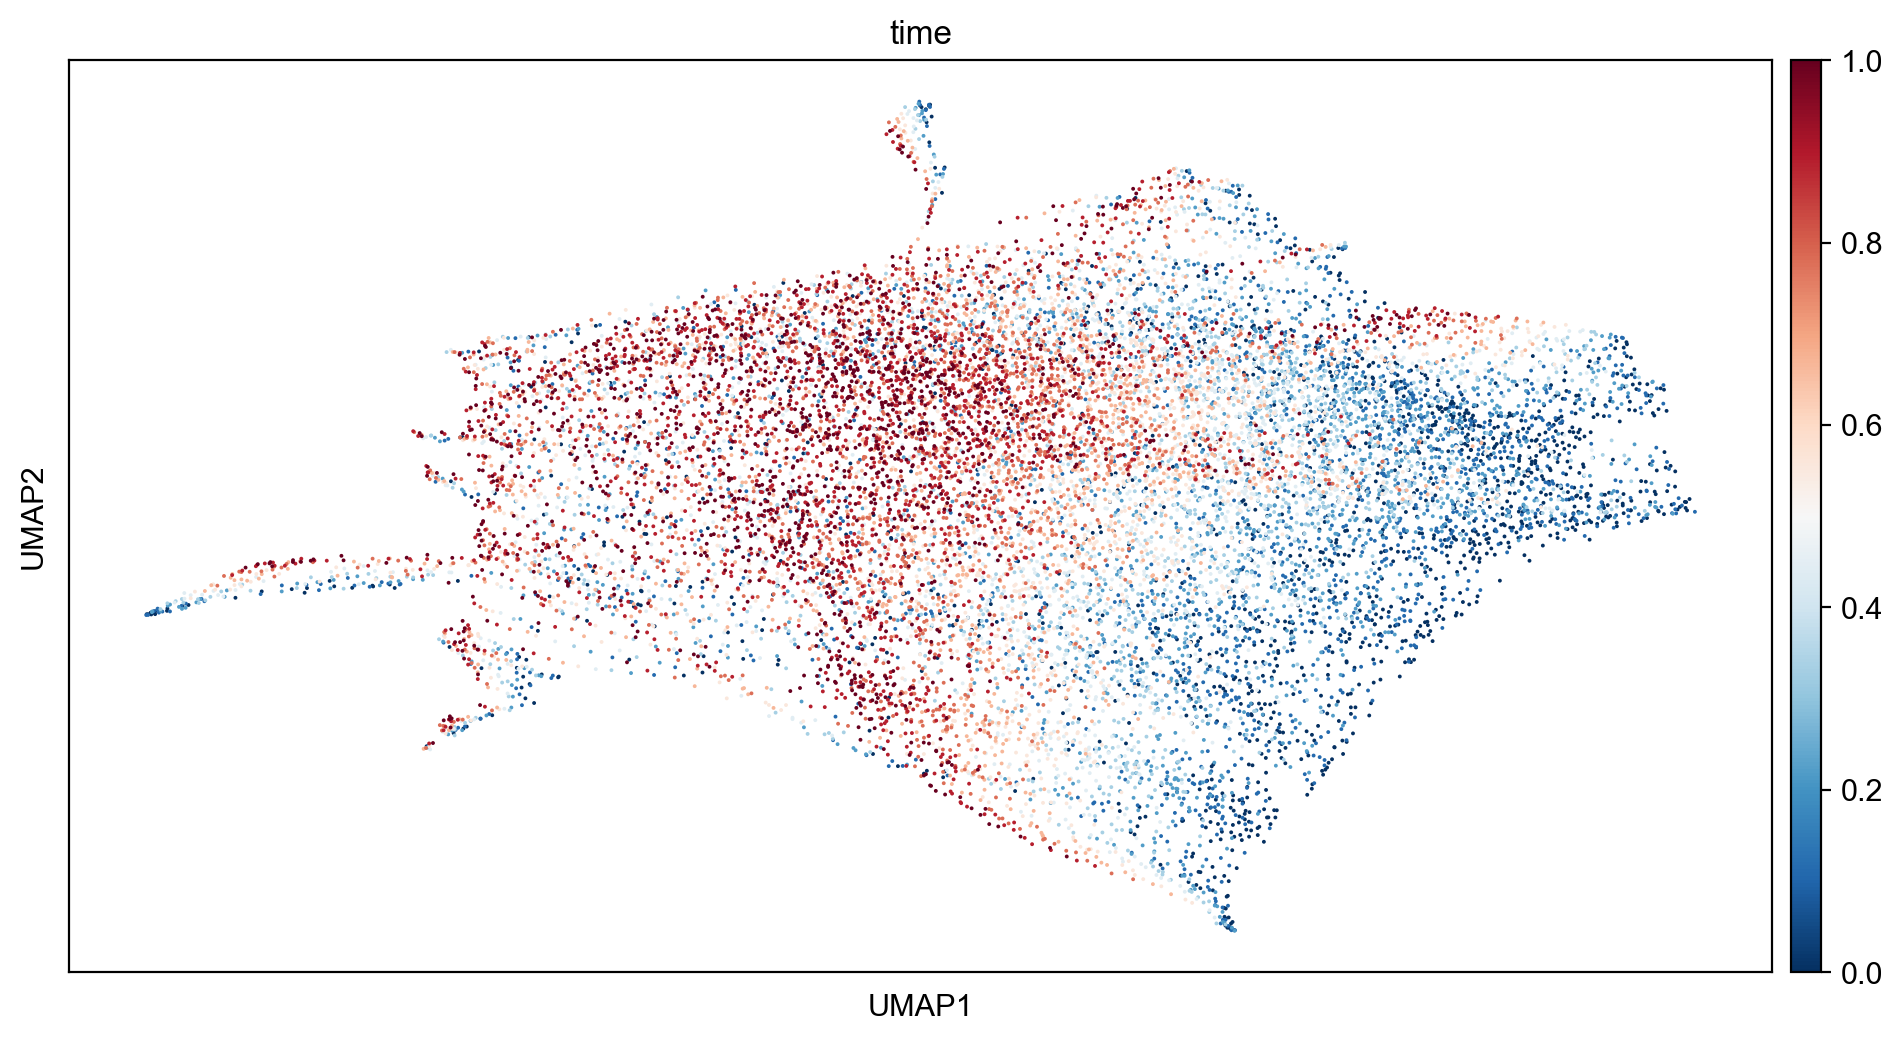

In [32]:
sc.pl.umap(traj_adata, color="time")

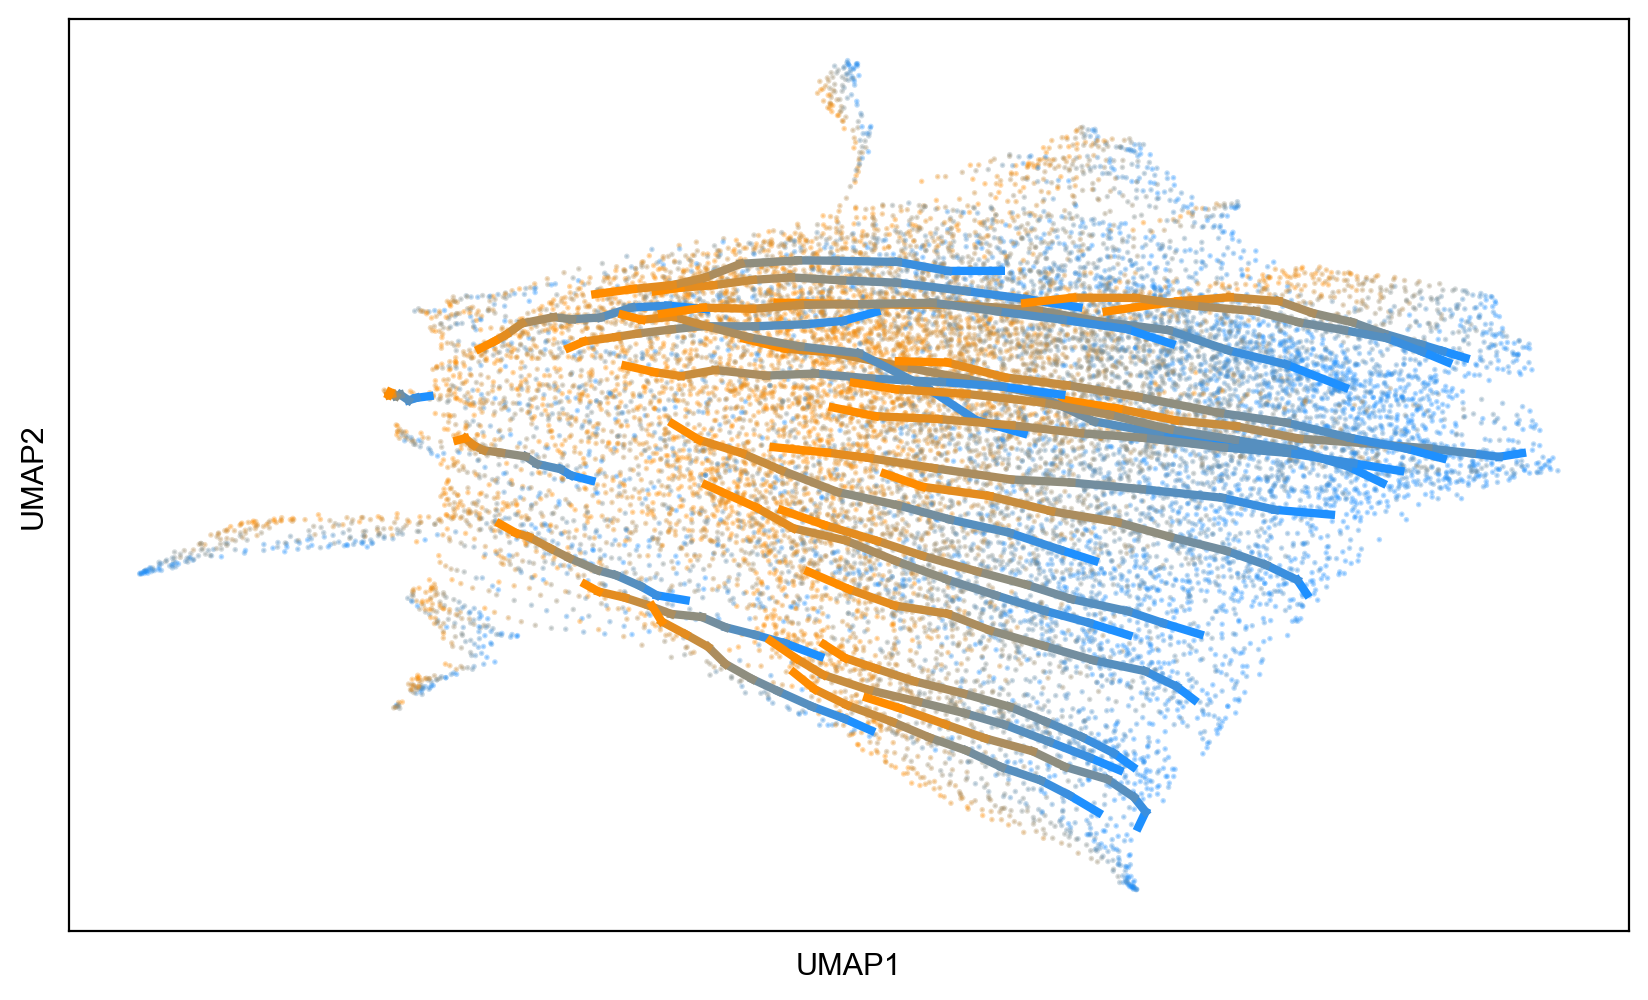

In [57]:
plt.rcParams["figure.figsize"] = (10,6)
n_traj = len(traj_adata) // 10
selected_trajs = [[i*10 + j for j in range(10)] for i in np.random.randint(n_traj, size=30)]
cmap = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "darkorange"])
# cmap = plt.get_cmap("summer")

plt.scatter(traj_adata.obsm["X_umap"][:, 0], traj_adata.obsm["X_umap"][:, 1], c=traj_adata.obs["time"], s=1, cmap = cmap, alpha=0.3)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.xticks([])
plt.yticks([])


n_colors = 9
colors = cmap(np.linspace(0, 1, n_colors))

for traj in selected_trajs:
    for i in range(n_colors):
        plt.plot(traj_adata.obsm["X_umap"][traj[i:i+2], 0], traj_adata.obsm["X_umap"][traj[i:i+2], 1], c=colors[i], linewidth=3)
plt.show()

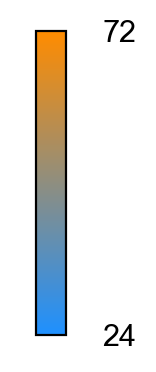

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

fraction = 1  # .05
vmin = 24
vmax = 72
cmap = cm = mpl.colors.LinearSegmentedColormap.from_list("", ["dodgerblue", "darkorange"])

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, 
                                  cmap=cmap
                                  # mpl.colors.Colormap("jets"),  # 'Blues'
                                 ),
            ax=ax, 
            # pad= .5, # .05, 
            # extend='both', 
            aspect=10,
            fraction=fraction, 
            orientation="vertical"
            )

cbar.set_ticks([vmin,vmax])
cbar.ax.tick_params(size=0)

for t in cbar.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(3.)

ax.axis('off')
plt.show()

## Baseline with no Flow Matching augmentation

In [150]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_mar_07_1.pt"), 
                                map_location=torch.device('cpu'))

In [151]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [152]:
path_length = 2
all_traj_baseline = []

with torch.no_grad():

    for i in tqdm(range(start_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(start_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        
        mycellpop.set_visible_state(gene_expr)
        
        traj = simulate_deterministic_trajectory(mycellpop, torch.linspace(0, path_length-1, 10))
        traj = traj[:, :, :mycellpop.n_genes, 0]

        all_traj_baseline.append(traj)
        
#         if i == 4:
#             break

100%|██████████| 64/64 [40:39<00:00, 38.12s/it]


In [153]:
all_traj_baseline_cat = torch.cat(all_traj_baseline)

In [154]:
obs_times = torch.cat([torch.linspace(0, path_length-1, 10)[None]]*len(all_traj_baseline_cat)).reshape(-1).numpy()

In [191]:
traj_baseline_adata = ad.AnnData(all_traj_baseline_cat.reshape(-1, 4000).numpy(), obs=obs_times)

In [192]:
traj_baseline_adata.obs = traj_baseline_adata.obs.rename(columns={0: "time"})

In [183]:
sc.tl.pca(traj_baseline_adata)
sc.pp.neighbors(traj_baseline_adata, n_neighbors=50)

## Earth Mover distances

In [33]:
from scipy.spatial import distance_matrix
import scipy
import pandas as pd
import ot

In [53]:
def compute_emd(X_1, X_2):
    dist_mat = distance_matrix(X_1, X_2)
    samp_weight_1 = np.ones(dist_mat.shape[0]) / dist_mat.shape[0]
    samp_weight_2 = np.ones(dist_mat.shape[1]) / dist_mat.shape[1]
    return ot.emd2(samp_weight_1, samp_weight_2, dist_mat)

In [178]:
obs_bis_adata = obs_adata.copy()

In [35]:
obs_bis_adata.var.reset_index(inplace=True)
traj_adata.var.reset_index(inplace=True)
traj_baseline_adata.var.reset_index(inplace=True)

NameError: name 'traj_adata' is not defined

In [179]:
obs_bis_adata.obs["type"] = "ground_truth"

In [225]:
import anndata as ad
both_adata = ad.concat([obs_bis_adata, traj_adata, traj_baseline_adata])

In [226]:
sc.tl.pca(both_adata, svd_solver="arpack", n_comps=50)

In [227]:
target_dist = both_adata[both_adata.obs["time"] == 72.]

In [228]:
all_res_df = pd.DataFrame(columns=["time", "emd"])

for seed in range(5):

    n_traj = len(both_adata[both_adata.obs["type"] == "generated"]) // 10
    first_point_traj = [10*i for i in np.random.randint(n_traj, size=len(target_dist))]

    X_targ = target_dist.obsm["X_pca"]

    for j in range(10):
        j_time_point_traj = [j + 10*i for i in np.random.randint(n_traj, size=len(target_dist))]
        X_j = both_adata[both_adata.obs["type"] == "generated"][j_time_point_traj].obsm["X_pca"]
        emd = compute_emd(X_targ, X_j)

        res_df = pd.DataFrame([[48*j/9, emd]], columns=["time", "emd"])
        all_res_df = pd.concat([all_res_df, res_df])

In [229]:
all_res_baseline_df = pd.DataFrame(columns=["time", "emd"])

for seed in range(5):

    n_traj = len(both_adata[both_adata.obs["type"] == "generated (baseline)"]) // 10
    first_point_traj = [10*i for i in np.random.randint(n_traj, size=len(target_dist))]

    X_targ = target_dist.obsm["X_pca"]

    for j in range(10):
        j_time_point_traj = [j + 10*i for i in np.random.randint(n_traj, size=len(target_dist))]
        X_j = both_adata[both_adata.obs["type"] == "generated (baseline)"][j_time_point_traj].obsm["X_pca"]
        emd = compute_emd(X_targ, X_j)

        res_df = pd.DataFrame([[48*j/9, emd]], columns=["time", "emd"])
        all_res_baseline_df = pd.concat([all_res_df, res_df])

In [230]:
initial_dist = both_adata[both_adata.obs["time"] == 24.]

emd_lower_bound = []

for j in range(5):
    rand_half = np.random.randint(len(initial_dist), size=len(initial_dist) // 2)
    X_half_1  = initial_dist[rand_half].obsm["X_pca"]
    X_half_2  = initial_dist[[i for i in range(len(initial_dist)) if i not in rand_half]].obsm["X_pca"]

    emd_lower_bound.append(compute_emd(X_half_1, X_half_2))

print(emd_lower_bound)

[0.7329220456369914, 0.7504646274286979, 0.7241069649445001, 0.722189419162615, 0.7286211416051619]


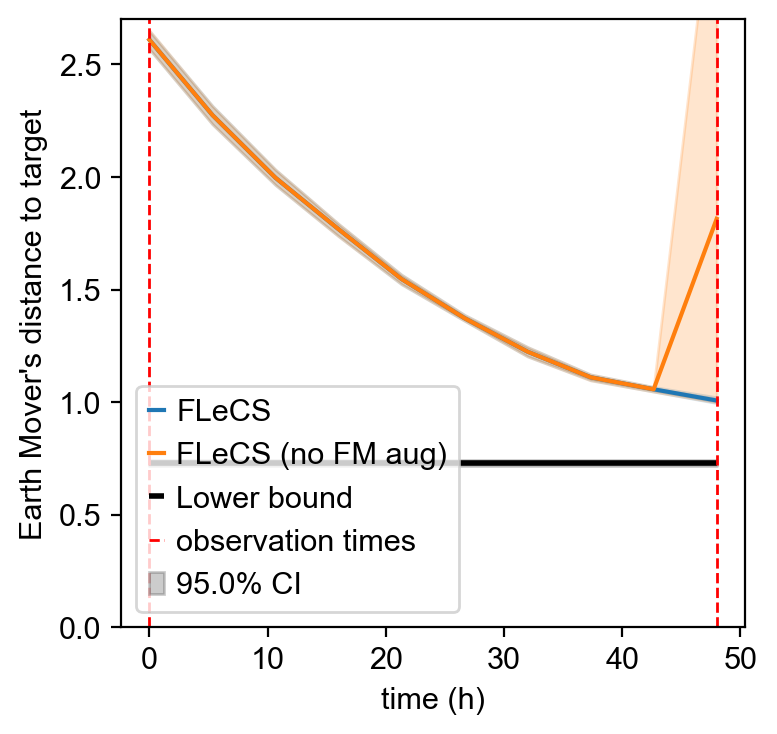

In [231]:
plt.rcParams["figure.figsize"] = (4,4)
sns.lineplot(all_res_df, x="time", y="emd", label="FLeCS")
sns.lineplot(all_res_baseline_df, x="time", y="emd", label="FLeCS (no FM aug)")
plt.xlabel("time (h)")
plt.ylabel("Earth Mover's distance to target")

# Calculate mean and confidence interval for lower bound
mean_y = np.mean(emd_lower_bound)
confidence_level = 0.95
degrees_freedom = len(emd_lower_bound) - 1
confidence_interval = scipy.stats.t.interval(confidence_level, degrees_freedom, loc=mean_y, scale=scipy.stats.sem(emd_lower_bound))
lower_bound, upper_bound = confidence_interval

# Define X-axis range
x_start, x_end = 0, 48

# Plot horizontal line with confidence interval
plt.hlines(mean_y, x_start, x_end, color='black', linewidth=2, label='Lower bound')
plt.vlines(48, 0., 2.8, color='red', linewidth=1, label='observation times', linestyle='--')
plt.vlines(0, 0., 2.8, color='red', linewidth=1, linestyle='--')
plt.fill_betweenx([lower_bound, upper_bound], x_start, x_end, color='black', alpha=0.2, label=f"{confidence_level * 100}% CI")

plt.ylim([0, 2.7])

plt.legend()
plt.show()